### 0 序列模型

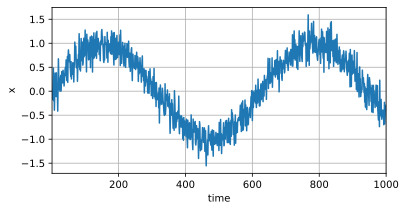

In [23]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# 数据生成（生成正弦函数点作为序列数据）
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [24]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [25]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机(回归问题)
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [26]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.057595
epoch 2, loss: 0.053108
epoch 3, loss: 0.051906
epoch 4, loss: 0.051954
epoch 5, loss: 0.049424


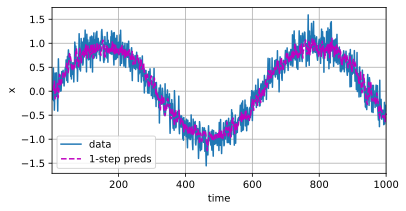

In [27]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

### 1 文本预处理
把词变成能够用于训练的数据

In [2]:
import collections
import re
from d2l import torch as d2l

In [3]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    # 把非字母部分变为空格
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


#### 把每一行都变为多个token：使用tokenizer分词器

In [7]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

tokens = tokenize(lines, 'word')
for i in range(11):
    print(tokens[i])

# tokens为二维列表，包含了所有预处理后的文本(行数 * 每行的词数)
len(tokens)

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


3221

#### 字典/词汇表
词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。 现在，让我们构建一个字典，通常也叫做词表（vocabulary）， 用来将字符串类型的词元映射到从
开始的数字索引中。 我们先将训练集中的所有文档合并在一起，对它们的唯一词元进行统计， 得到的统计结果称之为语料（corpus）。 然后根据每个唯一词元的出现频率，为其分配一个数字索引。 很少出现的词元通常被移除，这可以降低复杂性。 另外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元“unk”。 我们可以选择增加一个列表，用于保存那些被保留的词元， 例如：填充词元（“pad”）； 序列开始词元（“bos”）； 序列结束词元（“eos”）。

In [5]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            # 出现次数少于阈值的toekn不做处理(被视为unique token)
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [32]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:20])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9), ('my', 10), ('it', 11), ('had', 12), ('me', 13), ('as', 14), ('at', 15), ('for', 16), ('with', 17), ('but', 18), ('time', 19)]


In [33]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

# 第二行为空
print('文本:', tokens[2])
print('索引:', vocab[tokens[2]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]
文本: []
索引: []


整合所有功能

In [34]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab
# corpus: 一长串整数，每个整数为一个token的下标
corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

### 语言模型和数据集

一元语法、二元语法、三元语法（通常称为 n-gram 模型）是自然语言处理中用于描述词汇序列（通常是文本中单词）的模型。它们通过观察语言中相邻词汇之间的关系来构建语法模型，常用于文本生成、语言建模、机器翻译、信息检索等任务

#### 1.一元语法(Unigram)
一元语法是指单个词汇的模型，表示每个词都是独立的，不考虑任何上下文信息，仅基于词汇出现的频率，而不关心其他词汇的关系
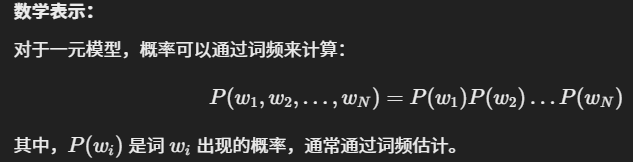

#### 2.二元语法(Bigram)
二元语法是指两个连续词汇的模型，表示词汇之间的关系。不仅考虑了当前词的出现频率，还考虑了`前一个词对当前词的影响`
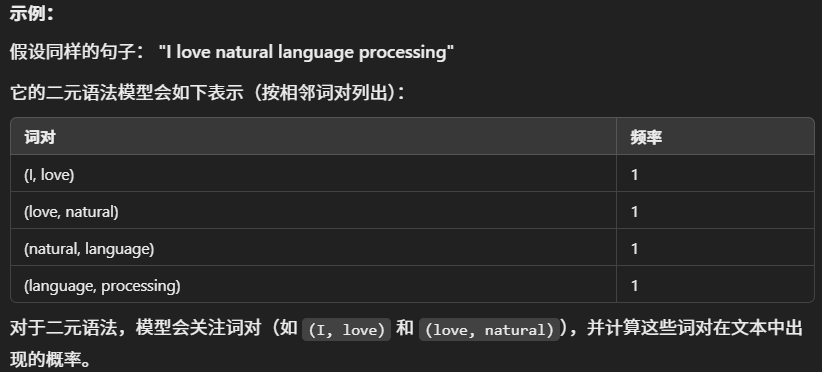
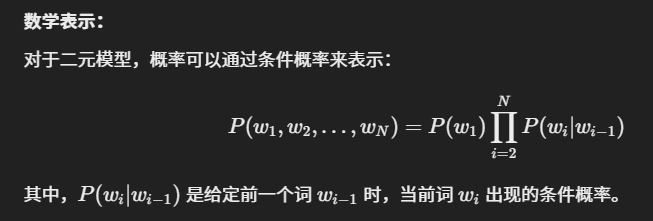

#### 3. 三元语法(Trigram)
三元语法是指 三个连续词汇 的模型，表示一个词受前两个词的影响。它考虑了更多的上下文信息，比一元语法和二元语法能够更好地捕捉到词汇之间的依赖关系。

定义：
三元语法 模型将文本中的每三对相邻词视为一个单位，计算每一组三个词的出现频率。
三元语法通过观察三个相邻词之间的依赖关系来建模文本。
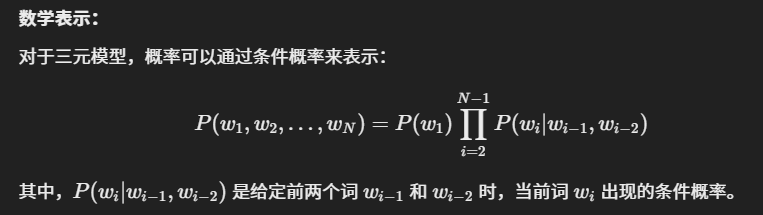

In [35]:
tokens = d2l.tokenize(read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]


在 自然语言处理 (NLP) 中，停用词（stop words）是指那些在文本处理中被认为不携带有意义、通常被忽略的词语。它们通常是一些常见的功能性词汇，如 连词、冠词、介词、代词、助动词等，这些词在句子中主要起到连接、组织语句结构的作用，而对句子整体语义贡献较小。\
明显的问题是词频衰减的速度相当地快，频率最高的词往往较少

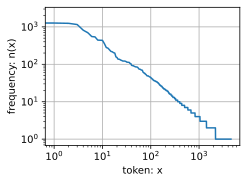

In [36]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

我们来看看二元语法的频率是否与一元语法的频率表现出相同的行为方式

In [37]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

这里值得注意：在十个最频繁的词对中，有九个是由两个停用词组成的， 只有一个与“the time”有关。 我们再进一步看看三元语法的频率是否表现出相同的行为方式

In [38]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

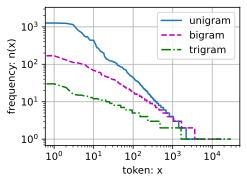

In [39]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

1. 除了一元语法词，单词序列似乎也遵循齐普夫定律， 尽管公式 (8.3.7)中的指数更小 （指数的大小受序列长度的影响）；

2. 词表中元组的数量并没有那么大，这说明语言中存在相当多的结构， 这些结构给了我们应用模型的希望；

3. 很多元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。 作为代替，我们将使用基于深度学习的模型。

读取长序列数据(两种采样方法)\
(从训练的文本corpus中一次读取一个batch的文本)

#### 方法一：随机采样
在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。 在迭代过程中，来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻。 对于语言建模，目标是基于到目前为止我们看到的词元来预测下一个词元， 因此标签是移位了一个词元的原始序列。

In [40]:
import torch
import random
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列(长度为num_steps)"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    # 随机偏移量:每个data epoch之前随机丢掉一些数据
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    # 即每个子序列开始的下标
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

下面我们生成一个从0到34的序列。 假设批量大小为2，时间步数为5，这意味着可以生成$\left \lfloor(35-1)/5\right \rfloor=6 $ 
个“特征－标签”子序列对。 如果设置小批量大小为2，我们只能得到3个小批量。

In [41]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 4,  5,  6,  7,  8],
        [14, 15, 16, 17, 18]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [15, 16, 17, 18, 19]])
X:  tensor([[29, 30, 31, 32, 33],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[30, 31, 32, 33, 34],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])


#### 方法二：顺序分区
在迭代过程中，除了对原始序列可以随机抽样外， 我们还可以保证两个相邻的小批量中的子序列在原始序列上也是相邻的。 这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区。

In [42]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [43]:
lists = []
seq_len, bsz, voc = 5, 2, 28
for i in range(seq_len):
    X = torch.randn(bsz, voc)
    lists.append(X)
torch.cat(lists, dim=0).shape
    

torch.Size([10, 28])

In [44]:
from torch.nn import functional as F
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [20, 21, 22, 23, 24]])
X:  tensor([[10, 11, 12, 13, 14],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [25, 26, 27, 28, 29]])


In [45]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [46]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

### 循环神经网络的从零开始实现

In [47]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [48]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [49]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [50]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
 
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# 初始化隐藏状态，在0时刻时，没有上一刻的隐变量，因此传入一个初始化状态
def init_rnn_state(batch_size, num_hiddens, device):
    # 暂时做为一个tuple，在RNN中只有一个元素
    # 在接下来的LSTM中会有多个元素
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def rnn(inputs, state, params):
    # !!!!inputs的形状：(时间步数量，批量大小，词表大小)!!!!!
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小 or embed_size)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [51]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def __call__(self, X, state):
        # 输入的X形状: (批量大小×时间步数)
        # 即一个批量中多个序列，每个序列中一个词代表一个数字(idx)
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        # one_hot之后的形状: (时间步数×批量大小×词表大小)
        # 然后输入rnn
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)
    
    

检查输出是否具有正确的形状。 例如，隐状态的维数是否保持不变。\
我们可以看到输出形状是（时间步数$\times$批量大小，词表大小）， 而隐状态形状保持不变，即（批量大小，隐藏单元数）

In [52]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

#### 预测
让我们首先定义预测函数来生成prefix之后的新字符， 其中的prefix是一个用户提供的包含多个字符的字符串。\
在循环遍历prefix中的开始字符时， 我们不断地将隐状态传递到下一个时间步，但是不生成任何输出，这被称为预热（warm-up）期， 因为在此期间模型会自我更新（例如，更新隐状态）， 但不会进行预测。\
预热期结束后，隐状态的值通常比刚开始的初始值更适合预测， 从而预测字符并输出它们。

In [53]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    # 生成初始状态
    state = net.begin_state(batch_size=1, device=device)
    # 把prefix第一个词在词表的index放入output
    outputs = [vocab[prefix[0]]]
    # 把output最近预测的那个词的tensor输入(outputs[-1]表示最后的预测)
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    # 预热期将输入的话重新输入，从而使隐藏状态从初始化开始预热更新
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        # 这一步仅仅将prefix中的输入append到output中
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        # 将输出的one-hot码append到output中
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    # 最后将index转化为token
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [54]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller emujsnatza'

#### 梯度裁剪

In [55]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

#### 训练

In [56]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [57]:
X = torch.randn(2, 15)
X.reshape(-1).shape

torch.Size([30])

In [58]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 37390.5 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


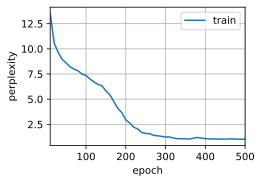

In [59]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())